### Accuracy: 0.8906
Легкие аугментации изображений

<small><font color=gray>Автор соревнования: <a href="https://www.hse.ru/org/persons/863761973/" target="_blank">Копылов Иван</a> ©2025</font></small><hr style="margin:0;background-color:silver">

**<font size=6>ХАКАТОН
МТС Х Л2Ш Х ВОСХОД</font>**

## Вычислительные ресурсы для решения задачи соревнования

Решение данной задачи скорее всего потребует использование вычислений на видеокарте (GPU, графическом или тензорном процессоре). Для этого вы можете использовать любые имеющиеся у вас ресурсы (ваш ноутбук, сервер друга). Тем не менее, мы рекомендуем вам использовать Google Colab, который предоставляет достаточные ресурсы для решения задачи соревнования. Выполните следующую команду:

In [50]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

zsh:1: command not found: nvidia-smi


Видно, что сейчас используется видеокарта NVIDIA Tesla T4 с 16 ГБ видеопамяти. Смотрите [подробнее](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) о запросе информации о видеокартах NVIDIA.

Обратите внимание, что выделенные ресурсы в бесплатной версии Google Colab [имеют ограничения](https://research.google.com/colaboratory/faq.html#resource-limits). Это означает, что при интенсивном обращении к видеокарте (более нескольких часов в день), вы можете увидеть сообщение "You cannot currently connect to a GPU due to usage limits in Colab." и потерять доступ к видеокарте на часы или даже на дни (при этом доступ к центральному процессору, предположительно, сохранится).

# Необходимый код
**Не удаляйте этот код.**

In [51]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os # загрузка основных библиотек для работы с данными

# Загрузка библиотеки pytorch и необходимых модулей
from torch.utils.data import random_split
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d
from torchvision.models import resnet50, mobilenet_v2, mobilenet_v3_small
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # округляет значения до 2 десятичных знаков

RunTimeLimit, t0 = 300, time.time() # ограничение по времени работы вашей модели и время начала работы

class Timer():
  def __init__(self, lim:'RunTimeLimit'=300): self.t0, self.lim, _ = time.time(), lim, print(f'отсчет ⏳ начался. У вашей модели есть только {lim} секунд. Удачи!')
  def ShowTime(self):
    msg = f'Время выполнения {time.time()-self.t0:.0f} с'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} секунд на предельное время выполнения!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 252 ms, sys: 125 ms, total: 377 ms
Wall time: 406 ms


In [52]:
# pip freeze | grep torch*

### Примеры изображений лиц из директории `train/female`

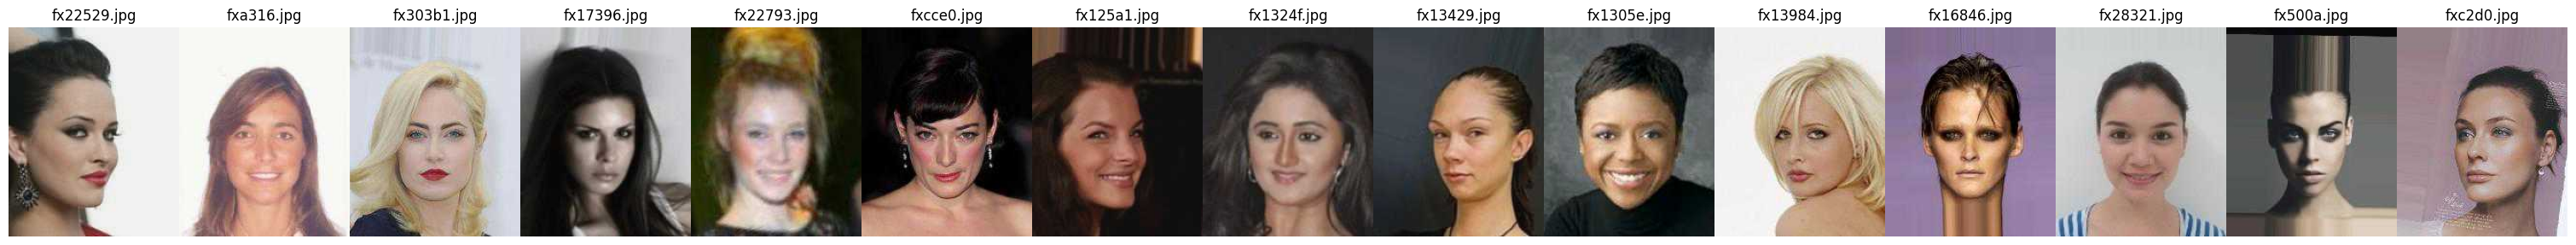

In [53]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

### Примеры изображений лиц из директории `train/male`

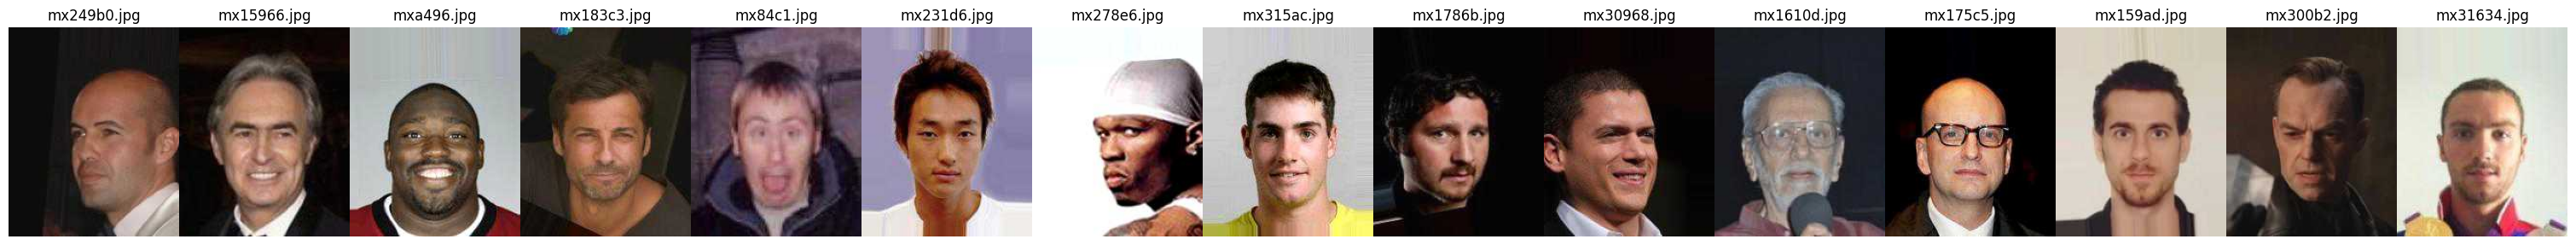

In [54]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [55]:
tmr = Timer()

отсчет ⏳ начался. У вашей модели есть только 300 секунд. Удачи!


<hr color=green size=40>

<font size=5>⏳</font> <strong><font color=green size=5>Ваш код, идеи, ссылки и документацию - все записываете здесь...</font></strong>

<font color=green> **Раздел для участников соревнования** (между символами ⏳): добавьте сюда свой код и документацию.


# Рекомендуемый код предобработки данных для работы в PyTorch

Не забудьте [зафиксировать генераторы случайных чисел](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) для воспроизводимости результата:

In [56]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # При запуске на бэкенде CuDNN необходимо задать еще два параметра
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Установите фиксированное значение для хэша
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Используется случайное число {seed}")

set_seed(0)

Используется случайное число 0


Следующие несколько ячеек нужны для загрузки обучающего и тестового набора данных в PyTorch как [ImageFolder datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html):
* `tDS` - обучающая выборка;
* `vDS` - валидационная выборка;
* `sDS` - тестовая выборка.

In [57]:
BS, image_size = 32, (224, 224)

train_transform = v2.Compose([
    v2.Resize(image_size, antialias=True),

    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=.2, contrast=.2),

    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize(image_size, antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
# !mv test/ labels/ && mkdir test && mv labels/ test/labels/

In [59]:
im_folder_train = ImageFolder(tDIR, transform=train_transform)
im_folder_test = ImageFolder(sDIR, transform=val_transform)

In [60]:
tDS, vDS = random_split(im_folder_train, lengths=[0.8, 0.2])

In [61]:
tDL = DataLoader(tDS, batch_size=BS, shuffle=True, pin_memory=True)
vDL = DataLoader(vDS, batch_size=BS, shuffle=False, pin_memory=True)
sDL = DataLoader(im_folder_test, batch_size=BS, shuffle=False, pin_memory=True)

Проверим правильность разбиения на выборки:

In [62]:
print(f"Train size: {len(tDS)}")
print(f"Val size: {len(vDS)}")
print(f"Test size: {len(sDL)}")
print(next(iter(tDL))[0][:10].sum())

Train size: 4000
Val size: 1000
Test size: 157
tensor(-883196.1875)


# Стартовое решение (базовая модель)

Заменим верхний слой предварительно обученной сверточной нейронной сети ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) и обучим только новый слой, при этом все остальные предобученные слои будут зафиксированы (заморожены):

In [63]:
RUN_FREEZE = False
EPOCHS_FREEZE = 2
GAMMA_FREEZE = 0.99
LR_FREEZE = 1e-3

RUN_UNFREEZE = True
EPOCHS_UNFREEZE = 5
GAMMA_UNFREEZE = 0.99
LR_UNFREEZE = 1e-4

In [64]:
# pm = mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)  # предобученная модель MobileNet_V2

from torchvision.models import mobilenet_v3_large
pm = mobilenet_v3_large(weights='IMAGENET1K_V2')

In [65]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(device)

mps


In [66]:
pm1 = Sequential(
    pm,
    LazyLinear(1)
)

In [67]:
def trainer(model, epoch, validate=True):
  losses = []

  for e in range(epoch):
    print(f"Эпоха: {e}")
    model.train()
    for i, (image, label) in enumerate(tDL):
      image = image.to(device)
      label = label.to(device).type(torch.float32)
      adamw.zero_grad()
      pred = model(image)
      loss = criterion(pred, label.unsqueeze(1))
      losses.append(loss)

      if i % 10 == 0:
        print(loss)

      loss.backward()
      adamw.step()
      scheduler.step()

    if validate:
      model.eval()

      s = 0
      for i, (image, label) in enumerate(vDL):
        image = image.to(device)
        label = label.to(device).type(torch.float32)
        with torch.no_grad():
          val_preds = nn.functional.sigmoid(model(image))
          s += ((val_preds > 0.5).type(torch.int) == label.unsqueeze(1)).sum()

      print(f"Точность (Accuracy): {s / (len(vDL) * BS)}")

  return losses

In [68]:
for l in pm1[0].parameters():
    l.requires_grad = False  # зафиксируем (заморозим) слои от обучения

adamw = torch.optim.AdamW(pm1.parameters(), lr=LR_FREEZE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(adamw, gamma=GAMMA_FREEZE)

criterion = nn.BCEWithLogitsLoss()
pm1 = pm1.to(device)

In [69]:

%%time
if RUN_FREEZE:
    hist = trainer(pm1, epoch=EPOCHS_FREEZE)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 μs


Дообучим все предобученные слои после их разблокировки:

In [70]:
for l in pm1[0].parameters():
    l.requires_grad = True  # разморозка слоев для обучения
    
adamw = torch.optim.AdamW(pm1.parameters(), lr=LR_UNFREEZE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(adamw, gamma=GAMMA_UNFREEZE)

In [71]:
%%time
if RUN_UNFREEZE:
    hist_trainable = trainer(pm1, epoch=EPOCHS_UNFREEZE)

Эпоха: 0
tensor(0.7488, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6170, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4089, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4434, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4642, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2874, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3982, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2769, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2616, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2346, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4388, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3433, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1116, device='mps:0', 

Выгрузим предсказания нейросети:

In [72]:
vIDs = [f[0].split('/')[-1].split('.')[0] for f in sDL.dataset.imgs] # получим индексы из имени файла изображений

In [73]:
with torch.no_grad():
    preds = []
    for img, _ in sDL:
        preds.append(nn.functional.sigmoid(pm1(img.to(device))).cpu().numpy().flatten())

In [74]:
pY = pd.DataFrame(np.concatenate(preds, axis=0), index=vIDs, columns=['y']) # метки предсказаний (1 - мужские лица, 0 - женские лица)
ToCSV((pY>0.5)*1, 'baseline')

В списке файлов в текущей директории появился файл `baseline.csv`, который, если загрузить его на страницу соревнования на kaggle, воспроизведет базовое решение с качеством (Accuracy) в общедоступном рейтинге команд соревнования (Public Leaderboard) `0.60400`. Ваша цель - построить модель, верно классифицирующую как можно больше изображений из тестовой выборки.

# **Источники и ссылки**:

<font size=5>⌛</font> <strong><font color=green size=5>Не превышайте ограничение времени, выделенного на работу вашей модели!</font></strong>

<hr color=green size=40>



In [75]:
tmr.ShowTime() # Измерьте время работы вашего кода, убедитесь, что оно менее 300 секунд. Не удаляйте этот код. Используйте как последнюю ячейку в тетрадке.

Время выполнения 122 с
